# Image Classification

## From Dogs and Cats to Pet Breeds

In [1]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

In [2]:
import tensorflow as tf
Path.BASE_PATH = path

In [ ]:
!pip install -Uqq fastai
!pip show fastai


Name: fastai
Version: 2.8.3
Summary: fastai simplifies training fast and accurate neural nets using modern best practices
Home-page: https://github.com/fastai/fastai
Author: Jeremy Howard, Sylvain Gugger, and contributors
Author-email: info@fast.ai
License: Apache Software License 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: cloudpickle, fastcore, fastdownload, fastprogress, fasttransform, matplotlib, packaging, pandas, pillow, pip, plum-dispatch, pyyaml, requests, scikit-learn, scipy, spacy, torch, torchvision
Required-by: 


In [3]:
(path/"images").ls()

(#7393) [Path('images/samoyed_69.jpg'),Path('images/staffordshire_bull_terrier_77.jpg'),Path('images/Abyssinian_97.jpg'),Path('images/Abyssinian_225.jpg'),Path('images/yorkshire_terrier_144.jpg'),Path('images/Sphynx_212.jpg'),Path('images/american_pit_bull_terrier_192.jpg'),Path('images/keeshond_68.jpg'),Path('images/Siamese_150.jpg'),Path('images/american_bulldog_205.jpg'),Path('images/newfoundland_158.jpg'),Path('images/keeshond_173.jpg'),Path('images/keeshond_90.jpg'),Path('images/Bombay_62.jpg'),Path('images/saint_bernard_171.jpg'),Path('images/pug_110.jpg'),Path('images/Abyssinian_139.jpg'),Path('images/basset_hound_103.jpg'),Path('images/saint_bernard_87.jpg'),Path('images/Russian_Blue_67.jpg')...]

In [4]:
fname = (path/"images").ls()[0]

In [5]:
re.findall(r'(.+)_\d+.jpg$', fname.name)

['samoyed']

In [6]:
import keras
print(keras.__version__)

3.10.0


In [29]:
import re
from pathlib import Path
import pandas as pd

path = untar_data(URLs.PETS)
img_dir = path/"images"
files = list(img_dir.glob("*.jpg"))

# Extract labels from filenames
def get_label(fname):
    return re.findall(r'(.+)_\d+.jpg$', fname.name)[0]

labels = [get_label(f) for f in files]
df = pd.DataFrame({'filepath': files, 'label': labels})
df.head()

for f in files:
    label = get_label(f)
    label_dir = img_dir / label
    label_dir.mkdir(exist_ok=True)
    f.rename(label_dir / f.name)



In [30]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    img_dir,
    image_size=(128, 128),
    batch_size=20,
    label_mode='categorical',
    seed = 42,
    validation_split = 0.1,
    subset = 'training'
    )

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    img_dir,
    image_size=(128, 128),
    batch_size=20,
    label_mode='categorical',
    seed = 42,
    validation_split = 0.1,
    subset = 'validation'
    )


Found 7390 files belonging to 37 classes.
Using 6651 files for training.
Found 7390 files belonging to 37 classes.
Using 739 files for validation.


In [31]:
class_names = train_dataset.class_names
num_classes = len(class_names)

In [32]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [61]:
base_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False
for layer in base_model.layers[-50:]:
    layer.trainable = True

In [62]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3)),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2, fill_mode='nearest'),
    tf.keras.layers.RandomZoom(0.1, fill_mode='nearest'),
    tf.keras.layers.Rescaling(1./255),
    base_model,
    # tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    # tf.keras.layers.MaxPooling2D(2,2),
    # tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    # tf.keras.layers.MaxPooling2D(2,2),
    # tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # tf.keras.layers.MaxPooling2D(2,2),
    # tf.keras.layers.Flatten(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])



In [63]:
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_12 (RandomFlip)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_12              │ (None, 128, 128, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_12 (RandomZoom)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_15 (Rescaling)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 2, 2, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_10     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 37)             │         2,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,075,717 (84.21 MB)

 Trainable params: 7,446,245 (28.41 MB)

 Non-trainable params: 14,629,472 (55.81 MB)

In [64]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
)

class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') >= 0.95 and logs.get('val_accuracy') >= 0.80:
            self.model.stop_training = True
            print("\nReached 95% train accuracy and 80% validation accuracy, so cancelling training!")

In [67]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=35,callbacks = [early_stop, EarlyStoppingCallback()])

Epoch 1/35
333/333 ━━━━━━━━━━━━━━━━━━━━ 32s 56ms/step - accuracy: 0.7026 - loss: 1.0504 - val_accuracy: 0.7442 - val_loss: 1.0130
Epoch 2/35
333/333 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.7141 - loss: 0.9687 - val_accuracy: 0.7267 - val_loss: 1.0845
Epoch 3/35
333/333 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - accuracy: 0.7329 - loss: 0.8741 - val_accuracy: 0.7402 - val_loss: 1.0894
Epoch 4/35
333/333 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - accuracy: 0.7298 - loss: 0.9007 - val_accuracy: 0.7375 - val_loss: 0.9975
Epoch 5/35
333/333 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accuracy: 0.7692 - loss: 0.7989 - val_accuracy: 0.7415 - val_loss: 1.1293
Epoch 6/35
333/333 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.7496 - loss: 0.8385 - val_accuracy: 0.7307 - val_loss: 1.1906
Epoch 7/35
333/333 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - accuracy: 0.7644 - loss: 0.8080 - val_accuracy: 0.7267 - val_loss: 1.1442
Epoch 8/35
333/333 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - accuracy: 0.7839 - loss: 0.7612 - 

add callbacks and prepare for deploy add validation set


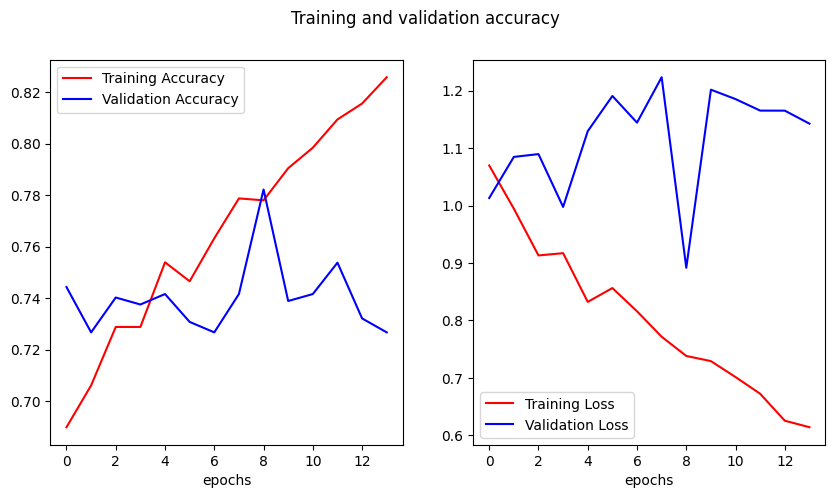

In [68]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')


In [69]:
model.save("my_model.keras")

In [ ]:
model = tf.keras.models.load_model("my_model.keras")

# Try accessing class names from model config
if hasattr(model, 'class_names'):
    class_names = model.class_names
else:
    print("Class names not found in model. You may need to supply them manually.")

Class names not found in model. You may need to supply them manually.


In [ ]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.543919,0.337799,0.115020,01:16


epoch,train_loss,valid_loss,error_rate,time
0,0.514452,0.301138,0.095399,01:09
1,0.361064,0.225642,0.070365,01:14
2,0.230261,0.190130,0.058187,01:12


In [ ]:
learn.export('pet_breed_classifier.pkl')

In [ ]:
import gradio as gr

learn_inf = load_learner('pet_breed_classifier.pkl')

def classify_image(img):
    pred, idx, probs = learn_inf.predict(img)
    return {pred: float(probs[idx])}

gr.Interface(fn=classify_image,
             inputs=gr.Image(type="pil"),
             outputs=gr.Label()).launch()

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://859710233e317f6dab.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## Presizing

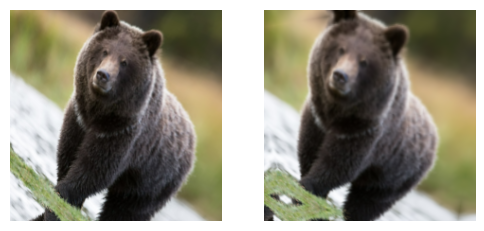

In [ ]:
dblock1 = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_y=parent_label,
                   item_tfms=Resize(460))
# Place an image in the 'images/grizzly.jpg' subfolder where this notebook is located before running this
dls1 = dblock1.dataloaders([(Path.cwd()/'images'/'grizzly.jpg')]*100, bs=8)
dls1.train.get_idxs = lambda: Inf.ones
x,y = dls1.valid.one_batch()
_,axs = subplots(1, 2)

x1 = TensorImage(x.clone())
x1 = x1.affine_coord(sz=224)
x1 = x1.rotate(draw=30, p=1.)
x1 = x1.zoom(draw=1.2, p=1.)
x1 = x1.warp(draw_x=-0.2, draw_y=0.2, p=1.)

tfms = setup_aug_tfms([Rotate(draw=30, p=1, size=224), Zoom(draw=1.2, p=1., size=224),
                       Warp(draw_x=-0.2, draw_y=0.2, p=1., size=224)])
x = Pipeline(tfms)(x)
#x.affine_coord(coord_tfm=coord_tfm, sz=size, mode=mode, pad_mode=pad_mode)
TensorImage(x[0]).show(ctx=axs[0])
TensorImage(x1[0]).show(ctx=axs[1]);

### Checking and Debugging a DataBlock

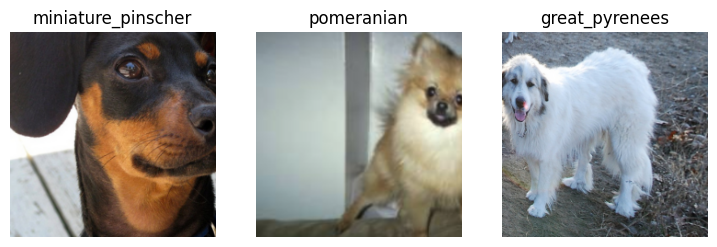

In [ ]:
dls.show_batch(nrows=1, ncols=3)

In [ ]:
pets1 = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 item_tfms=Resize(460),
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'))
pets1.summary(path/"images")

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/Persian_34.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=500x333
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/Persian_34.jpg
    applying partial gives
      Persian
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(7)

Final sample: (PILImage mode=RGB size=500x333, TensorCategory(7))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: Pipeline:

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 189MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.519738,0.319531,0.112991,01:02


epoch,train_loss,valid_loss,error_rate,time
0,0.499643,0.294744,0.093369,01:04
1,0.335886,0.212947,0.066306,01:05


## Cross-Entropy Loss

### Viewing Activations and Labels

In [ ]:
x,y = dls.one_batch()

In [ ]:
y

TensorCategory([ 2, 24, 25, 22,  2,  6,  9, 25,  0, 10, 30, 25,  7, 10, 30, 28,
                19, 11, 34,  5, 10, 30,  7, 20, 24, 27, 26, 26, 11, 36,  7,  0,
                10, 15, 27, 10, 20, 33, 13, 25, 17, 35, 31, 13,  2, 33, 19, 25,
                21,  4, 26, 24,  6, 21, 12, 32,  9, 17, 28, 31, 28, 26, 33, 15],
               device='cuda:0')

In [ ]:
preds,_ = learn.get_preds(dl=[(x,y)])
preds[0]

tensor([4.0286e-05, 4.8577e-06, 9.7478e-01, 1.5314e-05, 1.2602e-05, 2.9148e-06,
        6.4035e-05, 1.7597e-05, 6.2339e-03, 2.2077e-06, 1.8646e-02, 3.0031e-06,
        4.3643e-06, 5.4035e-07, 7.6408e-06, 9.0947e-07, 4.1375e-06, 5.1716e-06,
        1.3268e-06, 2.0037e-06, 2.8987e-07, 5.2205e-06, 1.0497e-06, 2.7408e-06,
        4.6100e-06, 2.7865e-05, 1.4689e-06, 3.0156e-06, 1.1480e-05, 1.6207e-05,
        3.4757e-05, 9.2436e-06, 4.3660e-06, 4.1786e-06, 9.0012e-07, 1.1387e-05,
        1.1935e-05])

In [ ]:
len(preds[0]),preds[0].sum()

(37, tensor(1.))

### Softmax

In [ ]:
plot_function(torch.sigmoid, min=-4,max=4)

NameError: name 'plot_function' is not defined

In [ ]:
#hide
torch.random.manual_seed(42);

In [ ]:
acts = torch.randn((6,2))*2
acts

In [ ]:
acts.sigmoid()

In [ ]:
(acts[:,0]-acts[:,1]).sigmoid()

In [ ]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts

### Log Likelihood

In [ ]:
targ = tensor([0,1,0,1,1,0])

In [ ]:
sm_acts

In [ ]:
idx = range(6)
sm_acts[idx, targ]

In [ ]:
from IPython.display import HTML
df = pd.DataFrame(sm_acts, columns=["3","7"])
df['targ'] = targ
df['idx'] = idx
df['result'] = sm_acts[range(6), targ]
t = df.style.hide_index()
#To have html code compatible with our script
html = t._repr_html_().split('</style>')[1]
html = re.sub(r'<table id="([^"]+)"\s*>', r'<table >', html)
display(HTML(html))

In [ ]:
-sm_acts[idx, targ]

In [ ]:
F.nll_loss(sm_acts, targ, reduction='none')

#### Taking the Log

Recall that cross entropy loss may involve the multiplication of many numbers.  Multiplying lots of negative numbers together can cause problems like [numerical underflow](https://en.wikipedia.org/wiki/Arithmetic_underflow) in computers.  Therefore, we want to transform these probabilities to larger values so we can perform mathematical operations on them.  There is a mathematical function that does exactly this: the *logarithm* (available as `torch.log`). It is not defined for numbers less than 0, and looks like this between 0 and 1:

In [ ]:
plot_function(torch.log, min=0,max=1, ty='log(x)', tx='x')

In [ ]:
plot_function(lambda x: -1*torch.log(x), min=0,max=1, tx='x', ty='- log(x)', title = 'Log Loss when true label = 1')

In [ ]:
from IPython.display import HTML
df['loss'] = -torch.log(tensor(df['result']))
t = df.style.hide_index()
#To have html code compatible with our script
html = t._repr_html_().split('</style>')[1]
html = re.sub(r'<table id="([^"]+)"\s*>', r'<table >', html)
display(HTML(html))

### Negative Log Likelihood

In [ ]:
loss_func = nn.CrossEntropyLoss()

In [ ]:
loss_func(acts, targ)

In [ ]:
F.cross_entropy(acts, targ)

In [ ]:
nn.CrossEntropyLoss(reduction='none')(acts, targ)

## Model Interpretation

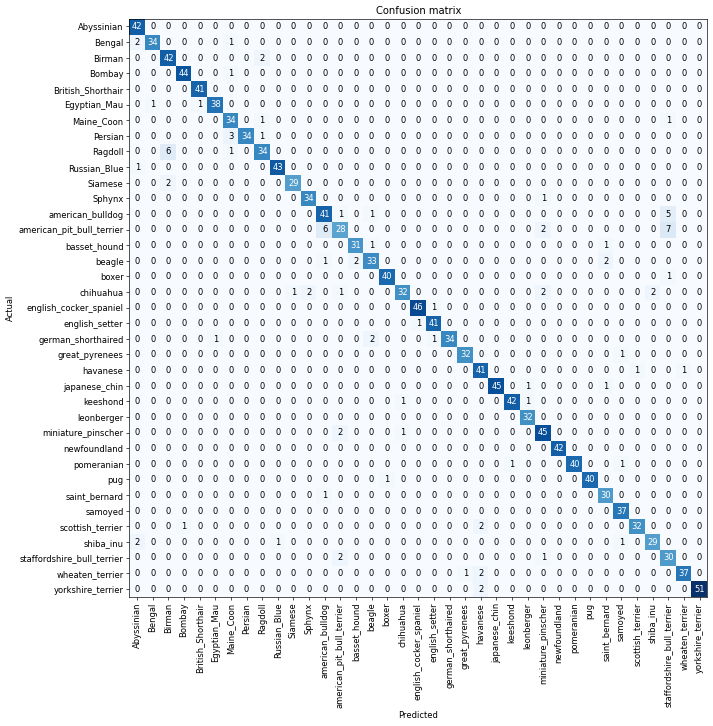

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=5)

## Improving Our Model

### The Learning Rate Finder

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,2.658783,4.945751,0.437754,01:01


epoch,train_loss,valid_loss,error_rate,time
0,4.176157,2.713528,0.754398,01:05


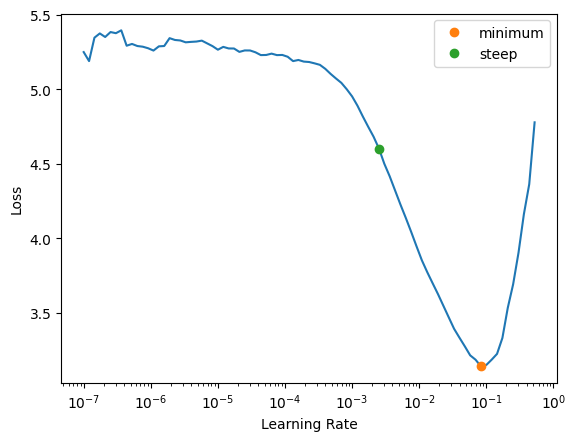

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

In [ ]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3)

### Unfreezing and Transfer Learning

In [ ]:
learn.fine_tune??

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(6, lr_max=1e-5)

### Discriminative Learning Rates

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

In [ ]:
learn.recorder.plot_loss()